In [1]:
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning, module='keras')

# Set up paths for training, validation, and test datasets
train_dir = r"T:\Snake Project\Dataset\train"  # Replace with your training dataset path
validation_dir = r"T:\Snake Project\Dataset\valid"  # Replace with your validation dataset path
test_dir = r"T:\Snake Project\Dataset\test"  # Replace with your test dataset path

# Initialize ImageDataGenerators for loading and augmenting images
train_datagen = ImageDataGenerator(
    rescale=1.0/255, 
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
validation_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Create image generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'  # Binary classification: snake or no snake
)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Build a deeper CNN model for binary classification
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(1024, activation='relu'),  # Increased dense layer units
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Add early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model_deeper.keras", monitor="val_accuracy", save_best_only=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=40,  # Increased epochs for better training with a deeper model
    validation_data=validation_generator,
    callbacks=[early_stopping, checkpoint]
)

# Print final training and validation accuracy
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]
print(f"Final Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Final Validation Accuracy: {val_accuracy * 100:.2f}%")

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Save the entire model in Keras format
model.save("snake_detection_model_16Layers_Demo.keras")
print("Model saved")


Found 4360 images belonging to 2 classes.
Found 1358 images belonging to 2 classes.
Found 1070 images belonging to 2 classes.
Epoch 1/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 126s 901ms/step - accuracy: 0.6364 - loss: 0.5956 - val_accuracy: 0.6414 - val_loss: 0.5430
Epoch 2/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 109s 790ms/step - accuracy: 0.6374 - loss: 0.5355 - val_accuracy: 0.6414 - val_loss: 0.5381
Epoch 3/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 114s 833ms/step - accuracy: 0.7273 - loss: 0.4845 - val_accuracy: 0.7887 - val_loss: 0.4358
Epoch 4/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 108s 788ms/step - accuracy: 0.8283 - loss: 0.3859 - val_accuracy: 0.8454 - val_loss: 0.3807
Epoch 5/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 107s 783ms/step - accuracy: 0.8586 - loss: 0.3392 - val_accuracy: 0.8505 - val_loss: 0.3202
Epoch 6/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 114s 833ms/step - accuracy: 0.8672 - loss: 0.3147 - val_accuracy: 0.8623 - val_loss: 0.3401
Epoch 7/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 114s 831ms/step - accuracy: 0.8869 - loss:

Model loaded successfully!
ALERT: Snake detected!
Alarm sound played successfully!


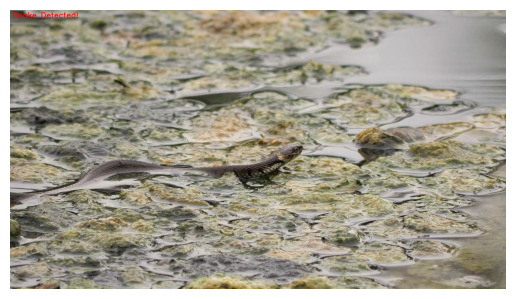

ALERT: Snake detected in the video!


In [1]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import winsound  # For playing the alarm sound on Windows

# Load the trained model
model = load_model(r"T:\Snake Project\Model\Snake_model.keras")
print("Model loaded successfully!")

# Set the video file or camera feed
video_path = r"T:\Study\Project\000\Snake2.mp4"
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

frame_width = 224
frame_height = 224
frame_skip = 5
frame_count = 0
snake_detected = False
alarm_triggered = False  # To prevent continuous alarm triggering

# Initialize Matplotlib for frame display
plt.ion()
fig, ax = plt.subplots()

# Function to play alarm sound
def play_alarm_sound():
    alarm_path = r"T:\Snake Project\Audio\Warn.mpeg"
    try:
        winsound.PlaySound(alarm_path, winsound.SND_FILENAME)
        print("Alarm sound played successfully!")
    except Exception as e:
        print(f"Error playing sound: {e}")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    if frame_count % frame_skip != 0:
        continue

    resized_frame = cv2.resize(frame, (frame_width, frame_height))
    normalized_frame = resized_frame / 255.0
    input_frame = np.expand_dims(normalized_frame, axis=0)

    prediction = model.predict(input_frame, verbose=0)
    if prediction[0][0] > 0.5:  # Assuming binary classification (snake vs non-snake)
        snake_detected = True

        # Display detection text on the frame
        cv2.putText(frame, "Snake Detected!", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        # Trigger alarm sound only once per detection
        if not alarm_triggered:
            print("ALERT: Snake detected!")
            play_alarm_sound()  # Play the alarm sound
            alarm_triggered = True

    # Display the frame using Matplotlib
    ax.clear()
    ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    ax.axis('off')
    plt.pause(0.001)

cap.release()
plt.close()

if snake_detected:
    print("ALERT: Snake detected in the video!")
else:
    print("No snakes detected in the video.")